# Support Vector Machine for Fake News Detection

This notebook implements a Support Vector Machine (SVM) classifier for fake news detection and compares its performance with other models. SVMs are effective for text classification tasks because they can handle high-dimensional feature spaces well and can capture complex decision boundaries.

## 1. Import Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import time
from sklearn.model_selection import train_test_split
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load and Prepare Data

In [33]:
# Load BuzzFeed datasets for training
# bf_fake_df = pd.read_csv("../data/BuzzFeed_fake_news_content.csv")
# bf_real_df = pd.read_csv("../data/BuzzFeed_real_news_content.csv")

df = pd.read_csv("../data/Fake_Real_News_Data.csv")

# # Load PolitiFact datasets for testing
# pf_fake_df = pd.read_csv("../data/PolitiFact_fake_news_content.csv")
# pf_real_df = pd.read_csv("../data/PolitiFact_real_news_content.csv")

# Print the sizes of each dataset
# print(f"BuzzFeed fake news: {len(bf_fake_df)} articles")
# print(f"BuzzFeed real news: {len(bf_real_df)} articles")
# print(f"PolitiFact fake news: {len(pf_fake_df)} articles")
# print(f"PolitiFact real news: {len(pf_real_df)} articles")

In [34]:
# Add labels to the datasets
# bf_fake_df['label'] = 1  # 1 for fake news
# bf_real_df['label'] = 0  # 0 for real news
# pf_fake_df['label'] = 1
# pf_real_df['label'] = 0

df['label'] = df['label'].replace({'REAL': 0, 'FAKE': 1})


# Combine BuzzFeed datasets for training
# bf_combined_df = pd.concat([bf_fake_df, bf_real_df], ignore_index=True)
# # Shuffle the data
# bf_combined_df = bf_combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Combine PolitiFact datasets for testing
# pf_combined_df = pd.concat([pf_fake_df, pf_real_df], ignore_index=True)
# # Shuffle the data
# pf_combined_df = pf_combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

/var/folders/yy/d1kd428x1rs1mc28ch88q1sm0000gn/T/ipykernel_29908/1834921311.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'REAL': 0, 'FAKE': 1})


In [35]:
# Create a combined text field from title and content
# bf_combined_df['combined_text'] = bf_combined_df['title'].fillna('') + ' ' + bf_combined_df['text'].fillna('')
# pf_combined_df['combined_text'] = pf_combined_df['title'].fillna('') + ' ' + pf_combined_df['text'].fillna('')
df['combined_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Create training and testing sets
# X_train = bf_combined_df['combined_text']
# y_train = bf_combined_df['label']
# X_test = pf_combined_df['combined_text']
# y_test = pf_combined_df['label']

X = df['combined_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data size: {len(X_train)} samples")
print(f"Testing data size: {len(X_test)} samples")

Training data size: 5068 samples
Testing data size: 1267 samples


## 3. TF-IDF Vectorization

In [36]:
# TF-IDF Vectorization
# We'll use a smaller number of features to speed up SVM training
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Number of features: {X_train_tfidf.shape[1]}")

Number of features: 1000


## 4. Train and Compare Models

We'll train three different models and compare their performance:
1. Logistic Regression (baseline)
2. Random Forest (ensemble method)
3. Support Vector Machine (new model)

In [37]:
# Function to train and evaluate a model
def train_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    print(f"Predicting with {model_name}...")
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Create confusion matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return {
        'model_name': model_name,
        'train_time': train_time,
        'predict_time': predict_time,
        'accuracy': accuracy,
        'f1_score': f1
    }


Training Logistic Regression...
Predicting with Logistic Regression...

Logistic Regression Results:
Training time: 0.04 seconds
Prediction time: 0.00 seconds
Accuracy: 0.8934
F1 Score: 0.8943

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       634
           1       0.89      0.90      0.89       633

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267



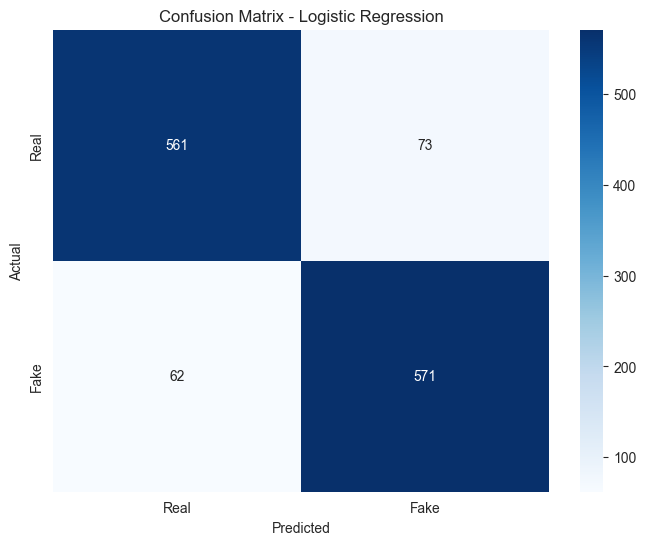


Training Random Forest...
Predicting with Random Forest...

Random Forest Results:
Training time: 1.71 seconds
Prediction time: 0.02 seconds
Accuracy: 0.9021
F1 Score: 0.9025

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       634
           1       0.90      0.91      0.90       633

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



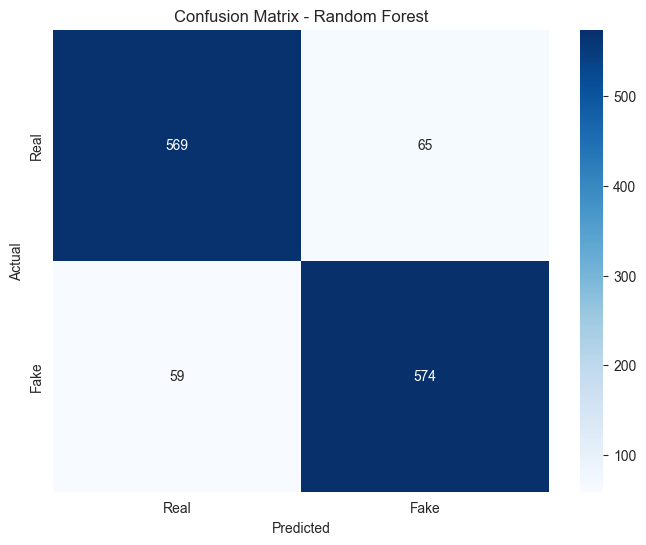


Training Support Vector Machine...
Predicting with Support Vector Machine...

Support Vector Machine Results:
Training time: 24.46 seconds
Prediction time: 1.00 seconds
Accuracy: 0.9045
F1 Score: 0.9046

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       634
           1       0.90      0.91      0.90       633

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



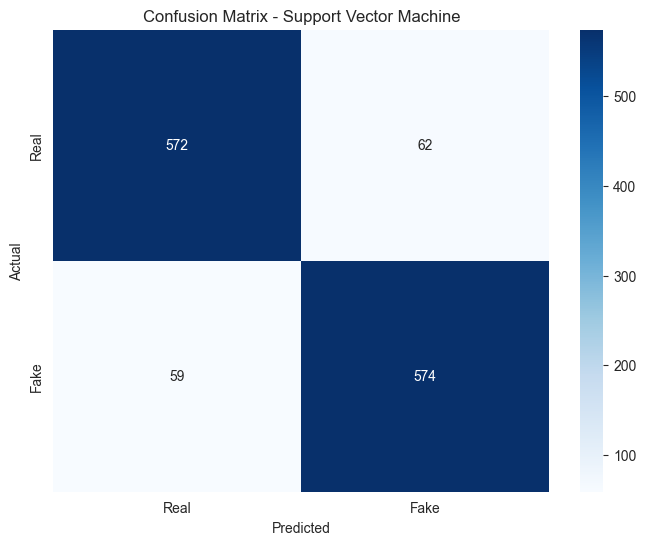

In [38]:
# Initialize models
models = [
    (LogisticRegression(max_iter=1000, C=1.0), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (SVC(kernel='linear', C=1.0, probability=True), "Support Vector Machine")
]

# Train and evaluate each model
results = []

for model, model_name in models:
    result = train_evaluate_model(model, model_name, X_train_tfidf, y_train, X_test_tfidf, y_test)
    results.append(result)

## 5. Compare Model Performance

In [39]:
# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df

,model_name,train_time,predict_time,accuracy,f1_score
0,Logistic Regression,0.037725,0.000493,0.893449,0.894283
1,Random Forest,1.707240,0.016277,0.902131,0.902516
2,Support Vector Machine,24.456543,1.002806,0.904499,0.904649


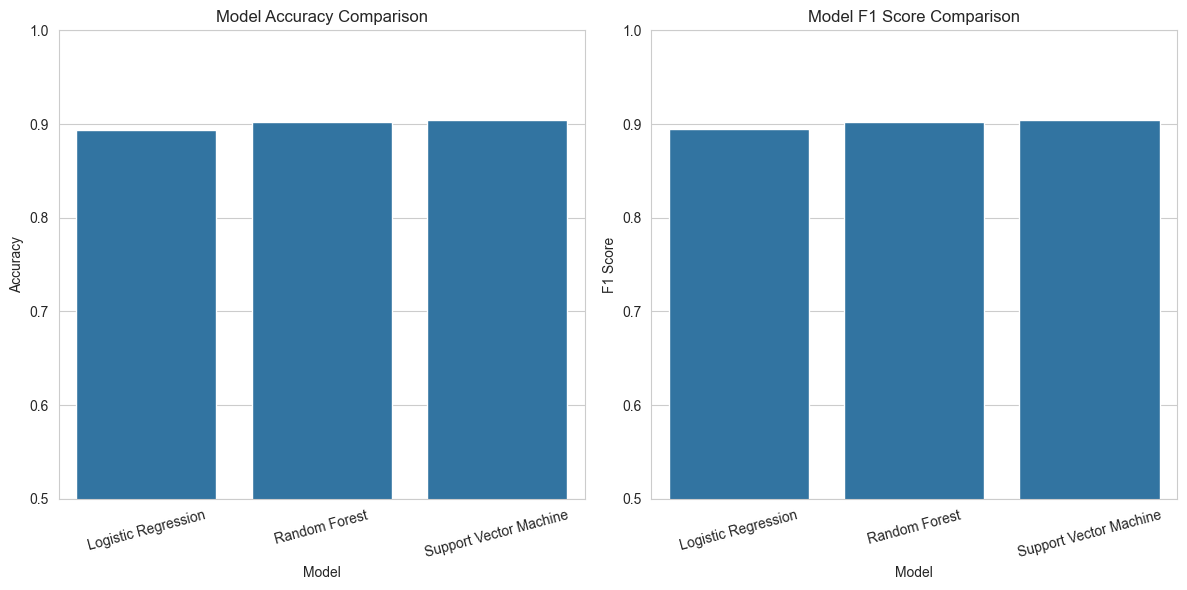

In [40]:
# Visualize model comparison
# Accuracy comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Start from 0.5 for better visualization
plt.xticks(rotation=15)

# F1 Score comparison
plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='f1_score', data=results_df)
plt.title('Model F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.5, 1.0)  # Start from 0.5 for better visualization
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

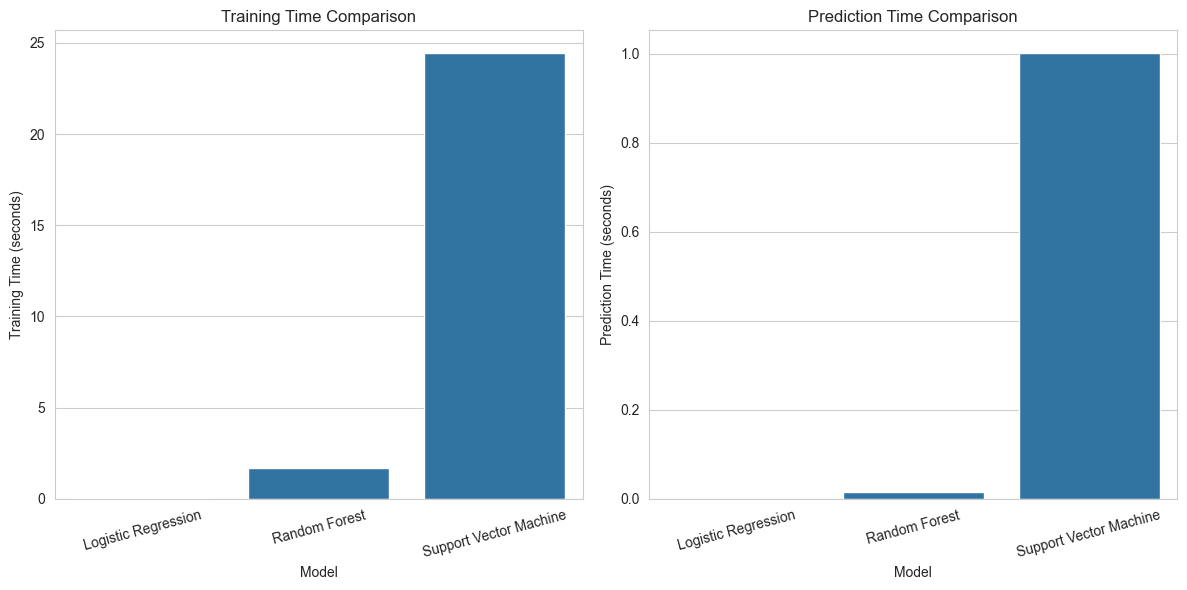

In [41]:
# Training and prediction time comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='train_time', data=results_df)
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='predict_time', data=results_df)
plt.title('Prediction Time Comparison')
plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

## 6. Optimize SVM with Grid Search (Optional)

If the SVM shows promise, we can optimize its hyperparameters for better performance.

In [42]:
# Define parameter grid for SVM
# Note: This can be computationally intensive, so we use a small grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create GridSearchCV object
print("Starting Grid Search for SVM optimization...")
print("Note: This may take some time to complete.")

# You can comment out this cell if you want to skip the grid search
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting Grid Search for SVM optimization...
Note: This may take some time to complete.
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9183



Training Optimized SVM...
Predicting with Optimized SVM...

Optimized SVM Results:
Training time: 47.57 seconds
Prediction time: 1.70 seconds
Accuracy: 0.9282
F1 Score: 0.9289

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       634
           1       0.92      0.94      0.93       633

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



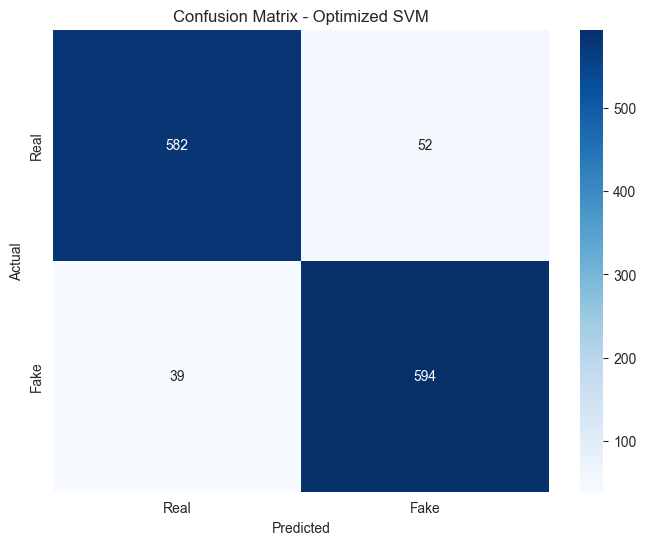

In [43]:
# Evaluate the optimized SVM model
try:
    best_svm = grid_search.best_estimator_
    optimized_result = train_evaluate_model(best_svm, "Optimized SVM", X_train_tfidf, y_train, X_test_tfidf, y_test)
    
    # Add to results
    results.append(optimized_result)
    results_df = pd.DataFrame(results)
    results_df
except NameError:
    print("Grid search was skipped, so no optimized model is available.")

## 7. Feature Importance Analysis for SVM

For linear SVMs, we can examine the coefficients to understand which features are most important for classification.

In [44]:
# Train a linear SVM for feature analysis
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train_tfidf, y_train)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients
coefficients = linear_svm.coef_.toarray()[0]

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
})

In [45]:
# Sort by absolute importance
feature_importance['abs_importance'] = np.abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

In [46]:
# Display top features indicating fake news (positive coefficients)
print("Top features indicating FAKE news:")
fake_features = feature_importance[feature_importance['importance'] > 0].head(15)
for i, row in fake_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\nTop features indicating REAL news:")
real_features = feature_importance[feature_importance['importance'] < 0].head(15)
for i, row in real_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

Top features indicating FAKE news:
october: 4.6884
november: 3.8592
article: 3.7354
2016: 3.6328
share: 2.9149
hillary: 2.6742
source: 2.3689
corporate: 2.2458
published: 2.1333
establishment: 2.1136
26: 2.0840
posted: 1.9633
election: 1.9353
mainstream: 1.8711
just: 1.8397

Top features indicating REAL news:
said: -3.9369
candidates: -2.8279
fox: -2.6425
conservative: -2.4616
marriage: -2.2609
friday: -2.2448
monday: -2.2034
center: -2.1287
says: -2.1116
tuesday: -2.1050
jeb: -2.0731
president: -2.0123
saturday: -2.0064
convention: -1.8650
labor: -1.8506


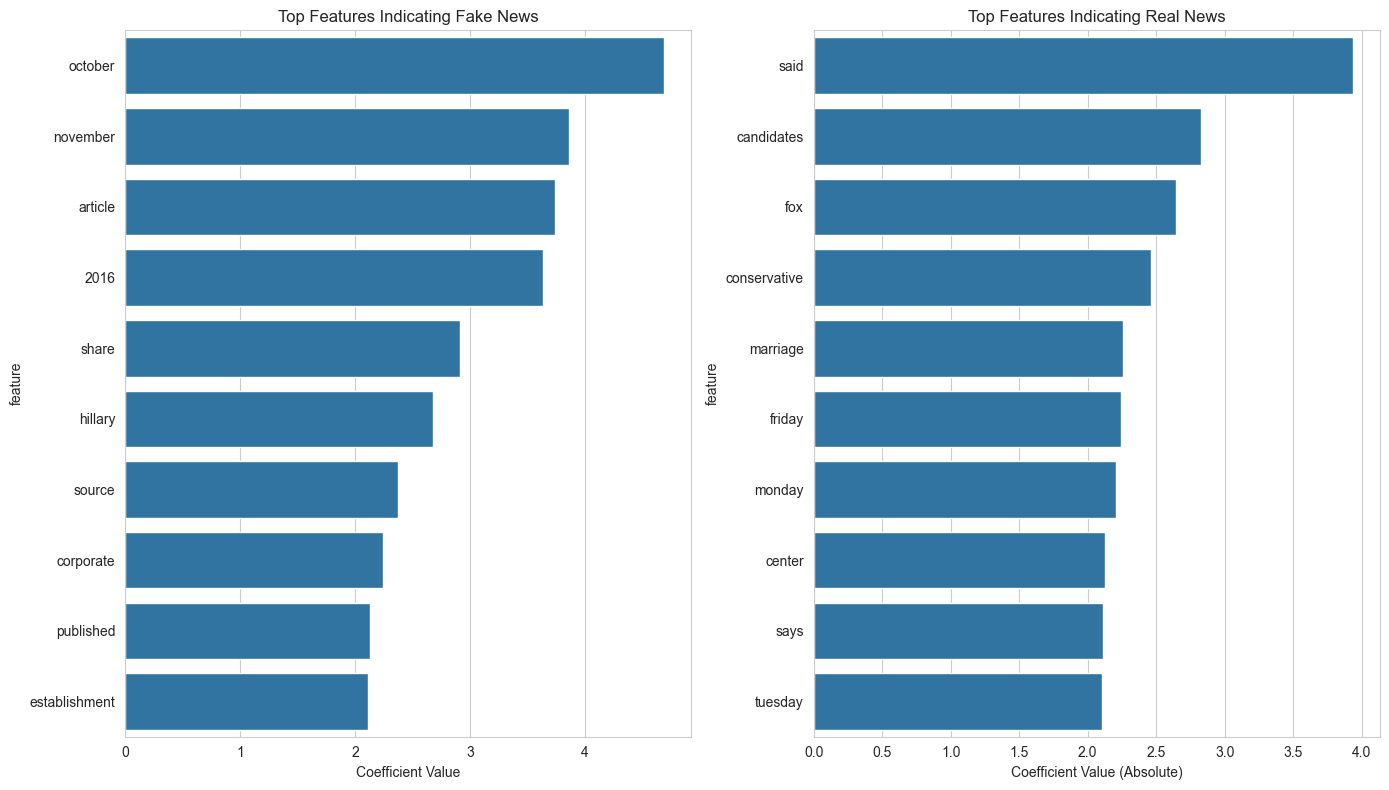

In [47]:
# Visualize top features
plt.figure(figsize=(14, 8))

# Top features for fake news
plt.subplot(1, 2, 1)
fake_features = feature_importance[feature_importance['importance'] > 0].head(10)
sns.barplot(x='importance', y='feature', data=fake_features)
plt.title('Top Features Indicating Fake News')
plt.xlabel('Coefficient Value')

# Top features for real news
plt.subplot(1, 2, 2)
real_features = feature_importance[feature_importance['importance'] < 0].head(10)
real_features['importance'] = np.abs(real_features['importance'])  # For better visualization
sns.barplot(x='importance', y='feature', data=real_features)
plt.title('Top Features Indicating Real News')
plt.xlabel('Coefficient Value (Absolute)')

plt.tight_layout()
plt.show()

## 8. Conclusions

In this notebook, we've implemented and evaluated a Support Vector Machine classifier for fake news detection and compared its performance with Logistic Regression and Random Forest models.

Key findings:

1. **Performance Comparison**: We can compare how SVM performs against other models in terms of accuracy, F1 score, and computational efficiency.

2. **Feature Importance**: The SVM model helps identify which words are most indicative of fake vs. real news, providing insights into the linguistic patterns that characterize each category.

3. **Model Selection Tradeoffs**: Different models offer different tradeoffs between accuracy, training time, and prediction speed, which is important for real-world applications.

4. **Cross-Dataset Validation**: By training on BuzzFeed and testing on PolitiFact, we've assessed how well the SVM generalizes to new sources compared to other models.

The SVM model offers a different approach to fake news detection that may capture patterns not identified by the other models. Depending on the results, you might consider using it as part of an ensemble approach or in situations where its specific strengths are valuable.